## D7041E - Mini project: Human Real-time Detection

### Group: Laura Bermejo, Lina Borg, Julie Labbé

#### References and sources
For the training of our model, we got inspired by this video: https://www.youtube.com/watch?v=V4Kkrz__hvo.

#### Requirements
The required libraries are super-gradient (for model), roboflow (for dataset) and supervision (for bounding boxes).

pip install -q super-gradients <br>
pip install -q roboflow <br>
pip install -q supervision

#### Dataset

##### Code to download the dataset

In [1]:
from roboflow import Roboflow
rf = Roboflow(api_key="DNm47rTel6WBxKZqAd9T")
project = rf.workspace("capricon").project("human-detection-q0nit")
dataset = project.version(2).download("yolov5")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Human-Detection-2 in yolov5pytorch:: 100%|██████████| 376/376 [00:01<00:00, 323.93it/s]


#### class Config Class definition

In [2]:
from typing import List, Dict

class config:
  #Project paths
  DATA_DIR: str = "Human-Detection-2"
  CHECKPOINT_DIR: str = "checkpoints"
  EXPERIMENT_NAME: str = "Project"

  #Datasets
  TRAIN_IMAGES_DIR: str ="train/images"
  TRAIN_LABELS_DIR: str = "train/labels"
  VAL_IMAGES_DIR: str = "valid/images"
  VAL_LABELS_DIR: str = "valid/labels"
  TEST_IMAGES_DIR: str = "test/images"
  TEST_LABELS_DIR: str = "test/labels"

  #Classes
  CLASSES: List[str] = ["human", "vehicle"]
  NUM_CLASSES: int = 2

  #Model 1
  # DEFINE HYPERPARAMETERS, YOU WILL HAVE TO CHANGE IT
  DATALOADER_PARAMS: Dict = {
      'batch_size':16,
      'num_workers':0
  }
  # THIS IS ALREADY SET, CHANGE ONLY DATALOADER PARAMS
  MODEL_NAME: str = 'yolo_nas_l'
  PRETRAINED_WEIGHTS: str ='coco'

#### Dataloaders initialization

In [3]:
from IPython.display import clear_output
from super_gradients.training import models, Trainer
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_val
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.metrics.classification_metrics import Accuracy
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

The console stream is logged into C:\Users\Julie\sg_logs\console.log


[2024-01-09 16:14:34] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it
[2024-01-09 16:14:34] WARNING - __init__.py - Failed to import pytorch_quantization
[2024-01-09 16:14:34,614] torch.distributed.elastic.multiprocessing.redirects: [WARNING] NOTE: Redirects are currently not supported in Windows or MacOs.
[2024-01-09 16:14:38] WARNING - calibrator.py - Failed to import pytorch_quantization
[2024-01-09 16:14:38] WARNING - export.py - Failed to import pytorch_quantization
[2024-01-09 16:14:39] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization
[2024-01-09 16:14:39] WARNING - env_sanity_check.py - Failed to verify operating system: Deci officially supports only Linux kernels. Some features may not work as expected.


In [4]:
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.TRAIN_IMAGES_DIR,
        'labels_dir': config.TRAIN_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.TRAIN_IMAGES_DIR,
        'labels_dir': config.TRAIN_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.TRAIN_IMAGES_DIR,
        'labels_dir': config.TRAIN_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

[2024-01-09 16:14:39] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 159/159 [00:00<00:00, 1630.89it/s]
[2024-01-09 16:14:39] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 159/159 [00:00<00:00, 1870.30it/s]
[2024-01-09 16:14:39] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.


#### Visualization

Indexing dataset annotations: 100%|██████████| 159/159 [00:00<00:00, 1963.00it/s]


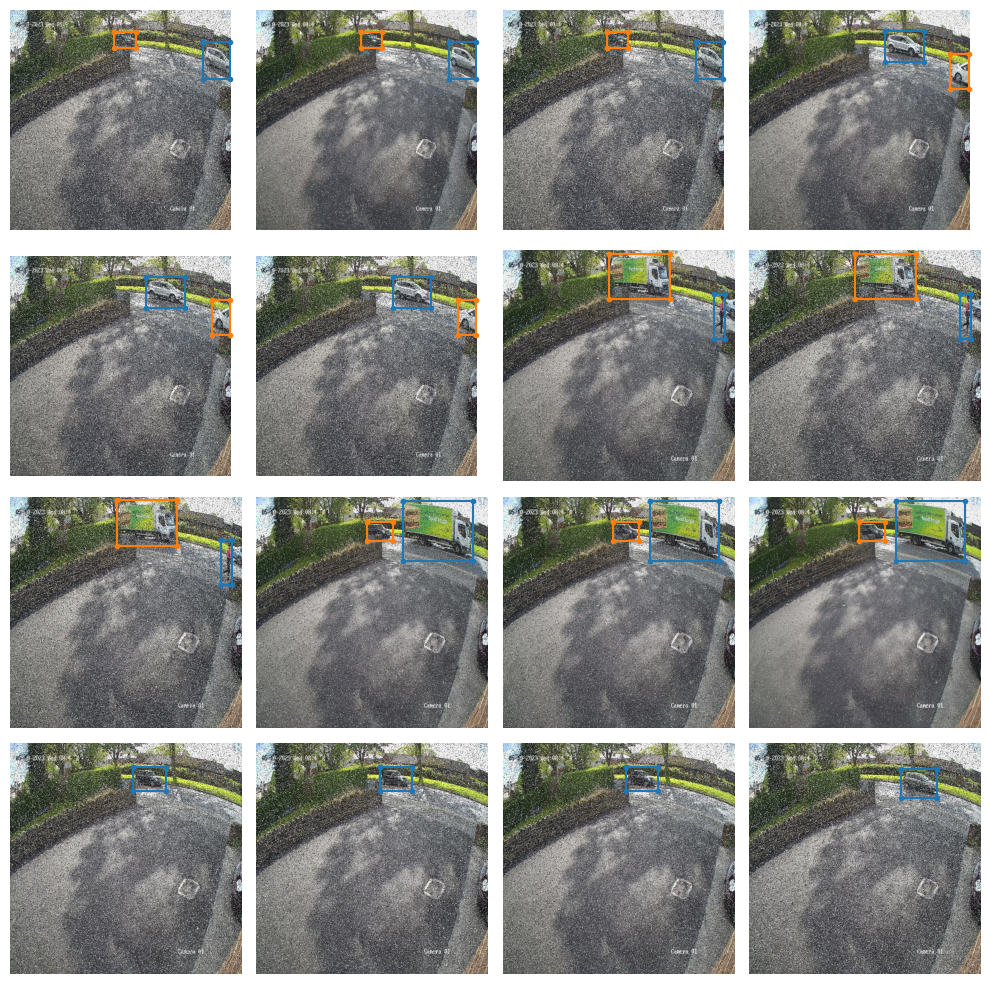

In [5]:
val_data.dataset.plot()

#### Training hyperparameters

In [6]:
# YOU HAVE TO SET THE HYPERPARAMETERS IN THIS VARIABLE
train_params = {
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    "max_epochs": 1,
    "mixed_precision": True,
    "loss" : PPYoloELoss (
        use_static_assigner=False,
        # NOTE: num_classes needs to be defined here
        num_classes=config.NUM_CLASSES,
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            # NOTE: num_classes needs to be defined here
            num_cls=config.NUM_CLASSES,
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.8
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

#### Training

##### Download the model

In [7]:
model = models.get(config.MODEL_NAME, num_classes=config.NUM_CLASSES, pretrained_weights=config.PRETRAINED_WEIGHTS)

[2024-01-09 16:14:42] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
[2024-01-09 16:14:42] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_l


##### Initialize training

In [8]:
trainer = Trainer(experiment_name=config.EXPERIMENT_NAME, ckpt_root_dir=config.CHECKPOINT_DIR)

##### Train

In [9]:
#trainer.train(model=model, training_params=train_params, train_loader=train_data, valid_loader=val_data)

#### Charge best model

In [10]:
#import os

#avg_model = models.get(config.MODEL_NAME, num_classes=config.NUM_CLASSES, checkpoint_path=os.path.join(config.CHECKPOINT_DIR, config.EXPERIMENT_NAME, 'average_model.pth'))

#### Test with test_dataloaders

In [11]:
#trainer.test(model=avg_model, test_loader=test_data, test_metrics_list=DetectionMetrics_050(score_thres=0.1, top_k_predictions=300, num_cls=config.NUM_CLASSES, normalize_targets=True, post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01, nms_top_k=1000, max_predictions=300)))

#### Visualization

In [12]:
#import random
#import supervision as sv

#random.seed(10) # THE SEED CAN BE CHANGED

##### Build dataset object

In [13]:
# ds = sv.Dataset.from_yolo(images_directory_path=f"{config.DATA_DIR}/test/images", annotations_directory_path=f"{config.DATA_DIR}/test/labels", data_yaml_path=f"{config.DATA_DIR}/data.yaml", force_masks=False)
# predictions = {}
# CONFIDENCE_THRESHOLD = 0.5

##### Inference

In [14]:
# for image_name,image in ds.images.items():
#     result = list(avg_model.predict(image, conf=CONFIDENCE_THRESHOLD))[0]
#     detections = sv.Detections(xyxy=result.prediction.bboxes_xyxy, confidence=result.prediction.confidence, class_id=result.prediction.labels.astype(int))
#     predictions[image_name] = detections

##### Plot annotations vs predictions

In [15]:
# MAX_IMAGE_COUNT = 10
# n = min(MAX_IMAGE_COUNT, len(ds.images))

# keys = list(ds.images.keys())
# keys = random.sample(keys,n)

# box_annotator = sv.BoxAnnotator()

# images = []
# titles = []

# for key in keys:
#     frame_with_annotations = box_annotator.annotate(scene=ds.images[key].copy (), detections =  ds. annotations [key], skip_label=True)
#     images.append(frame_with_annotations)
#     titles.append('annotations')
#     frame_with_predictions = box_annotator. annotate( scene = ds.images[key].copy (),detections = predictions [key], skip_label=True)
#     images.append(frame_with_predictions)
#     titles.append('predictions')

# %matplotlib inline
# sv.plot_images_grid(images-images, titles-titles, grid_size=(n, 2), size=(2*4, n*4))

#### Systematically chosen hyper-parameters 
We are using the random search to systematically chose the hyper-parameters. Since it takes a long time to train the model, we are only searching for the best combination of two parameters, but we can definitely use the same process for more of them. Actually, the random search would even work better with more parameters and more iterations, but as mentioned, it takes a while to do.

We decided to test multiple initial learning rates which has an impact on how much the parameters will update. We also test multiple weight decay for the optimizer. The optimizer Adam uses weight decay to penalize large weights to reduce overfitting tendencies. A higher value of weight decay will penalize more the large weights.

In [16]:
import numpy as np

# Hyperparameter search space
hyperparam_space = {
    "initial_lr": [3e-4, 5e-4, 7e-4], # TODO: find out what this does
    "optimizer_params": [{"weight_decay": 0.0015}, {"weight_decay": 0.001}, {"weight_decay": 0.002}]
}

# Random search
num_iterations = 5
best_score = -float('inf')
best_hyperparams = None

for _ in range(num_iterations):
    # Randomly sample hyperparameters from the search space
    train_params["initial_lr"] = np.random.choice(hyperparam_space["initial_lr"])
    train_params["optimizer_params"] = np.random.choice(hyperparam_space["optimizer_params"])

    # Train the model using the sampled hyperparameters and get the score
    trainer.train(model=model, training_params=train_params, train_loader=train_data, valid_loader=val_data)
    test_results = trainer.test(model=model, test_loader=test_data, test_metrics_list=[
        Accuracy(),
        DetectionMetrics_050(
            score_thres=0.1, 
            top_k_predictions=300, 
            num_cls=config.NUM_CLASSES, 
            normalize_targets=True, 
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01, 
                nms_top_k=1000, 
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ])
    print(f"Test results: Accuracy: {test_results['Accuracy']}, DetectionMetrics: {test_results['DetectionMetrics_050']}")
    score = test_results['Accuracy']

    # Check if the current score is better than the previous best
    if score > best_score:
        best_score = score
        best_hyperparams = {"initial_lr": train_params["initial_lr"], "optimizer_params": train_params["optimizer_params"]}
print(best_score)
print(best_hyperparams)

# Use the best parameters for the next step
train_params["initial_lr"] = best_hyperparams["initial_lr"]
train_params["optimizer_params"] = best_hyperparams["optimizer_params"]


[2024-01-09 16:14:43] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20240109_161443_183322`
[2024-01-09 16:14:43] INFO - sg_trainer.py - Checkpoints directory: checkpoints\Project\RUN_20240109_161443_183322
[2024-01-09 16:14:43] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}


The console stream is now moved to checkpoints\Project\RUN_20240109_161443_183322/console_Jan09_16_14_43.txt


Object name `linear_epoch_step` is now deprecated. Please replace it with `LinearEpochLRWarmup`.
initialize_param_groups and update_param_groups usages are deprecated since 3.4.0, will be removed in 3.5.0 and have no effect. 
 Assign different learning rates by passing a mapping of layer name prefixes to lr values through initial_lr training hyperparameter (i.e initial_lr={'backbone': 0.01, 'default':0.1})
Mixed precision training is not supported on CPU. Disabling mixed precision. (i.e. `mixed_precision=False`)
[2024-01-09 16:14:45] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               0          (0 available on the machine)
    - Full dataset size:            159        (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             16         (num_gpus * batch_size)
    - Effective Batch size

RuntimeError: [enforce fail at inline_container.cc:424] . unexpected pos 99781824 vs 99781712

#### Cross-validation
When we first downloaded the data, it got separated into three folders: test, train, validate. For cross-validation, we will use `KFold` method from `scikit-learn` which divides our data into folds. More specifically, it will divide the training data into multiples folds for training and one for test data. However, since we already have a testing folder, we will disregard the one generated by the function `KFold`. We will also disregard the validate folder, as the process of cross-validation already does validation with one of the folds.

#### Performance of different seeds

The function `KFold()` accepts a parameter `random_state` to set a seed for the randomization of the elements in each fold. More specifically, the items in the dataset are shuffled before getting split. We will test three different seeds and evaluate their performance through precision and recall metrics.

In [ ]:
import numpy as np
import os
import cv2
from sklearn.model_selection import KFold

def read_data(path):
    dataset = []
    for filename in os.listdir(path):
        file_path = os.path.join(path, filename)
        if "images" in path:
            file = cv2.imread(file_path)
        if "labels" in path:
                with open(file_path, 'r') as file:
                    lines = file.readlines()
                    file = []
                    for line in lines:
                        values = line.strip().split()
                        try:
                            # Convert label to integer (values[0]) and ensure rest are floats
                            label = int(float(values[0]))
                            bbox_coords = [float(val) for val in values[1:]]
                            annotation = [label] + bbox_coords
                            file.append(annotation)
                        except ValueError as e:
                            print(f"Error parsing line '{line}' of file {file_path}: {e}")
                    file = np.array(file)
        dataset.append(file)
    return np.array(dataset)

def write_data(dataset, path):
    if not os.path.exists(path):
        os.makedirs(path)

    for i, file in enumerate(dataset):
        if "images" in path:
            filename = f"{i}.jpg"
            output_path = os.path.join(path, filename)
            cv2.imwrite(output_path, file)
        if "labels" in path:
            for i, annotation in enumerate(dataset):
                filename = f"{i}.txt"
                output_path = os.path.join(path, filename)

                with open(output_path, 'w') as file:
                    for value in annotation:
                        # Convert label to integer and keep bounding box coordinates as floats
                        label = str(int(value[0]))
                        bbox_coords = ' '.join([str(coord) for coord in value[1:]])
                        line = label + ' ' + bbox_coords
                        file.write(line)
                        file.write('\n')

def cross_validation(values, labels, seed):
    current_iteration = 0
    accuracies = []
    precisions = []
    recalls = []
    num_folds = 3
    kf = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

    for train_index, test_index in kf.split(values):
        values_train, _ = values[train_index], values[test_index]
        labels_train, _ = labels[train_index], labels[test_index]

        # In order to use the training function, we need to store the images and labels in respective folders
        output_path = dataset.location + f"/train_fold_{current_iteration}"
        write_data(values_train, output_path + "/images")
        write_data(labels_train, output_path + "/labels")
        
        # Converts our new separated datasets into Dataloaders
        train_data = coco_detection_yolo_format_train(
            dataset_params={
                'data_dir': config.DATA_DIR,
                'images_dir': f"train_fold_{current_iteration}/images", 
                'labels_dir': f"train_fold_{current_iteration}/labels",
                'classes': config.CLASSES,
                'show_all_warnings': True,
            },
            dataloader_params=config.DATALOADER_PARAMS
        )

        # Train and test
        trainer.train(model=model, training_params=train_params, train_loader=train_data, valid_loader=val_data)
        test_results = trainer.test(model=model, test_loader=test_data, test_metrics_list=[
            Accuracy(),
            DetectionMetrics_050(
                score_thres=0.1, 
                top_k_predictions=300, 
                num_cls=config.NUM_CLASSES, 
                normalize_targets=True, 
                post_prediction_callback=PPYoloEPostPredictionCallback(
                    score_threshold=0.01, 
                    nms_top_k=1000, 
                    max_predictions=300,
                    nms_threshold=0.7
                )
            )
        ])
        print(f"Test results: Accuracy: {test_results['Accuracy']}, DetectionMetrics: {test_results['DetectionMetrics_050']}")
        accuracies.append(test_results['Accuracy'])

        current_iteration += 1

    average_accuracy = sum(accuracies) / len(accuracies)
    print(f"Average accuracy for seed {seed} = {average_accuracy}")

In [ ]:
# Load data in order to split it in folds
path = dataset.location + "/train"
loaded_dataset = read_data(path + "/images")
loaded_labels = read_data(path + "/labels")
seeds = [1, 2, 3]
for seed in seeds:
    cross_validation(loaded_dataset, loaded_labels, seed)